# Семинар 5. Тестрование гипотез:

Краткий синопсис:
1. Ремайндер прошлого семинара
2. Задачки на критерии проверки гипотез
3. Вальд против Неймана-Пирсона aka битва за объем тестовой выборки
4. АБ тестирование с реальными даннами -- Вальд и Манн-Уитни
5. Вальд SRPT
6. Семплирование из резервуара. Или чем заменить np.random_choice (https://en.wikipedia.org/wiki/Reservoir_sampling)


### 1. Задачки на критерии для проверки гипотез

а. Построить критерий для проверки гипотезы $H_0: p \!= 1/2$ при альтернативной гипотезе $H_a : p \neq  1/2$ по результатам восьми испытаний, подчиняющихся схеме Бернулли. Вероятность ошибки первого рода $\alpha $ положить равной 0.05.
https://www.wolframalpha.com/input/?i=(p%2F(1-p))**x*2**8*(1-p)**8
https://www.wolframalpha.com/input/?i=C(8,0)+0.5+*+(1+-+0.5)%5E7

b*. Пять независимых одинаково нормально распределенных случайных величин приняли значения: $ [3.02; 2.96; 3.06; 3.07; 2.96] $ соответственно. Проверить гипотезу $H_0:\sigma^2 \!= 0.0036 $ при альтернативе $H_a: \sigma^2 > 0.0036$ при вероятности ошибки первого рода равной $0,01$

### 2. Вальд против Неймана-Пирсона aka битва за объем тестовой выборки

###### Классический критерий Вальда(kind reminder):

$$H_0 : \theta = \theta_0 ~~~vs.~~~H_1:\theta \ne \theta_0$$

$$W = \frac{\hat{\theta} - \theta_0}{\hat{se}} \rightarrow N(0, 1), ~~~n\rightarrow \inf$$

###### Критерий Вальда для последовательного анализа:

$$Z_i = \log \frac{p_0(X_i)}{p_1(X_1)}, ~~ S_k = \sum\limits_{i=1}^{k} Z_i$$

В нормальном случае:

$$Z_i = \frac{\mu_1 - \mu_0}{\sigma^2} \left[ X_i - \frac{\mu_1 + \mu_0}{2} \right]$$

###### Критерий Неймана-Пирсона:

$$H_0 : \theta = \theta_0 ~~~vs.~~~H_1:\theta = \theta_1$$

$$T = \frac{\mathcal{L}(\theta_1)}{\mathcal{L}(\theta_1)} = \exp\left[ \frac{n}{\sigma^2} (\mu_1 - \mu_0) \left[ \bar{X} - \frac{\mu_1 + \mu_0}{2} \right] \right]$$

В данной задаче у нас $H_0$: $\mu_0 = 0$, $\sigma = 1$

$H_1$: $\mu_0 = r = 0.1 $, $\sigma = 1$

In [9]:
%pylab inline
# число повторений Монте-Карло
replications = 1000

# объем выборок, для которого будем вычислять 
# ошибки 1 и 2 рода
sample_lengths = np.arange(10, 1000, 10)

Populating the interactive namespace from numpy and matplotlib


C:\Users\kondr\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'sample', 'test', 'iterable']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
# будем проверять 
r = 0.1
sigma = 1.

In [11]:
def neyman_pearson_compute(sample, r=0.1, sigma=1.):
    """
    Процедура, вычисляющая значение статистики Неймана-Пирсона в случае нормального распределения
    """
    n = len(sample)
    X_n = np.sum(sample)
    return (r / sigma**2) * (X_n - n * r / 2.0)

def neyman_pearson_decide(criterion_value, r=0.1):
    """
    для проверки гипотезы о среднем значении
    нормального распределения такой порог h
    дает равные вероятности ошибки 1 и 2 рода
    """
    return int(criterion_value > r / 2.0)

<img src="hyp_right.png" alt="hyp_right" width="400"/>
<img src="hyp_wrong.png" alt="hyp_wrong" width="400"/>

In [13]:
def wald_sprt_compute(sample, r=0.1, sigma=1.):
    """
    Расчёт S_k написанных выше
    """
    zetas = [r / sigma**2 * (x - r / 2.0) for x in sample]
    return np.cumsum(zetas)

def wald_sprt_decide(criterion_values, thresholds):
    """
    Последовательно проверяем гипотезу пока не выйдет за границы
    """
    A, B = thresholds
    for value_time, value in enumerate(criterion_values):
        if value >= B:
            return value_time, 1.0    # верна гипотеза H_1
        elif value <= A:
            return value_time, 0.0    # верна гипотеза H_0
        else:
            continue       # продолжать наблюдения
    return value_time, 0.0      # по умолчанию не отклоняем гипотезу H_0

Код вычисления статистик, относящихся к вероятностям 1 и 2 рода, для критерия Неймана-Пирсона.

Для заданного объема выборки вычисляем долю ошибок 1 и 2 рода, она и равна приближенно вероятности этих ошибок.

In [15]:
wald_sprt_alphas = np.arange(0.01, 0.45, 0.01)
wald_sprt_betas = np.arange(0.01, 0.45, 0.01)

lower_thresholds = np.log(wald_sprt_betas / (1 - wald_sprt_alphas))
upper_thresholds = np.log((1 - wald_sprt_betas) / wald_sprt_alphas)

wald_sprt_p0_mean_decision_times = []
# wald_sprt_p1_decisions = defaultdict(list)

for A, B in zip(lower_thresholds, upper_thresholds):
    wald_sprt_p0_decisions = []
    wald_sprt_p0_decision_times = []

    for replication in range(replications):
        # для вычисления ошибки 1 рода (ложная тревога)
        # генерируем данные из гипотезы H_0 и вычисляем долю
        # решений в пользу гипотезы H_1: alpha = P(H_1 | H_0)
        p0_sample = np.random.normal(size=1000)
        wald_sprt_values = wald_sprt_compute(p0_sample, r, sigma)
        wald_sprt_decision_time, wald_sprt_decision = wald_sprt_decide(wald_sprt_values, thresholds=(A, B))
        wald_sprt_p0_decision_times.append(wald_sprt_decision_time)
        wald_sprt_p0_decisions.append(wald_sprt_decision)

    wald_sprt_p0_mean_decision_times.append(np.mean(wald_sprt_p0_decision_times))

In [16]:
neyman_pearson_alphas, neyman_pearson_betas = [], []
for sample_len in sample_lengths:
    neyman_pearson_p0_decisions = []
    neyman_pearson_p1_decisions = []
    for replication in range(replications):
        # для вычисления ошибки 1 рода (ложная тревога)
        # генерируем данные из гипотезы H_0 и вычисляем долю
        # решений в пользу гипотезы H_1: alpha = P(H_1 | H_0)
        
        p0_sample = np.random.normal(size=sample_len)
        neyman_pearson_value = neyman_pearson_compute(p0_sample, r, sigma)
        neyman_pearson_decision = neyman_pearson_decide(neyman_pearson_value)
        neyman_pearson_p0_decisions.append(neyman_pearson_decision)
        
        # для вычисления ошибки 2 рода (пропуск цели)
        # генерируем данные из гипотезы H_1 и вычисляем долю
        # решений в пользу гипотезы H_0: beta = P(H_0 | H_1)

        p1_sample = np.random.normal(loc=0.1, size=sample_len)
        neyman_pearson_value = neyman_pearson_compute(p1_sample, r, sigma)
        neyman_pearson_decision = neyman_pearson_decide(neyman_pearson_value, r)
        neyman_pearson_p1_decisions.append(neyman_pearson_decision)

    neyman_pearson_alphas.append(np.mean(neyman_pearson_p0_decisions))
    neyman_pearson_betas.append(1 - np.mean(neyman_pearson_p1_decisions))

Text(0,0.5,'Probability of type I error')

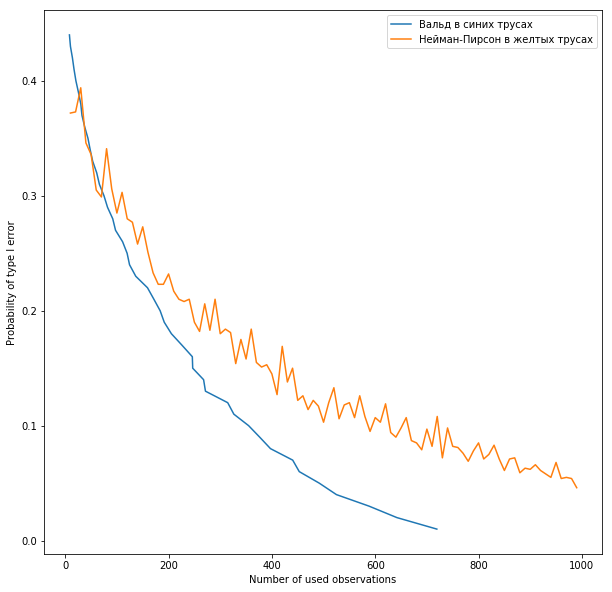

In [17]:
plt.figure(figsize=(10,10))
plot(wald_sprt_p0_mean_decision_times, wald_sprt_alphas, label='SPRT')
plot(sample_lengths, neyman_pearson_alphas, label='Neyman-Pearson')
legend(['Вальд в синих трусах','Нейман-Пирсон в желтых трусах'])
xlabel('Number of used observations')
ylabel('Probability of type I error')

Делаем вывод о том, что на малых выборках жёлтый трус Вальд уничтожает синего труса Пирсона.

### 4. АB тестирование с реальными даннами - Вальд и Манн-Уитни

https://docs.google.com/spreadsheets/d/19de13Thu9Okqx_01n0QLT4Zk_7ZcB6Og76LgxRXpyv0/edit#gid=1651438898

https://scholarworks.montana.edu/xmlui/handle/1/3507
 
5 версий сайта.

| Версия сайта | Общее количество визитов | Конверсия | Конверсия в процентах |
|--------------|--------------------------|-----------|-----------------------|
|  Version 1   | 10283                    | 3714      | 36%                   |
|  Version 2   | 2742                     | 1587      | 58%                   |
| Version 3    | 2747                     | 1652      | 60%                   |
| Version 4    | 3180                     | 1717      | 54%                   |
| Version 5    | 2064                     | 1348      | 65%                   |

Какой же вариант сайта лучше, а какие статистически объяснимые девиации от их своеобразных средних уровней?

In [1]:
data = np.array([
    [10283, 3714],
    [2742, 1587],
    [2747, 1652],
    [3180, 1717],
    [2064, 1348]
])

alpha = 0.05 / 5 # 5 потому что бонпари

NameError: name 'np' is not defined

###### Критерий Манна-Уитни(из лекции)
![](mww.png)

##### Критерий Манна-Уитни(крестьянско-рабочее определение)

статистика U считается следующим образом: 
  0. $U_1 = 0$
  1. Берутся все пары из двух выборок: $(x_i, y_i)$;
  2. Если $x_i > y_i$, то $U_1 += 1$;
  3. Если $x_i == y_i$, то $U_1 += 0.5$;
  4. Аналогично считается $U_2$ по парам $(y_i, x_i)$;
  5. $U = min(U_1, U_2)$
 
При больших размерах выборки:

$$U \sim N\left(\frac{mn}{2}, \frac{mn(n + m + 1)}{12}\right)$$

При большой выборке и возможных ничьих $\sigma$ считается по-другому:

$$
\sigma = \sqrt{ \frac{nm}{(m + n) (m + n - 1)} \cdot \left[ \frac{(m + n)^3 - (m + n)}{12} - \sum \frac{t_j^3 - t_j}{12} \right]},
$$

где $t_j$ -- количество ничьих.

In [30]:
def mann_whitney(conversion_1, conversion_2, alpha=0.05):
    """
    conversion = (N, n), где N -- общее число визитов, n -- конверсия
    True => H_0 отклоняется => средние не равны
    """
    U_1 = conversion_1[1] * (conversion_2[0] - conversion_2[1]) + conversion_1[1] * conversion_2[1] / 2 + (conversion_2[0] - conversion_2[1]) * (conversion_1[0] - conversion_1[1]) / 2
    U_2 = conversion_2[1] * (conversion_1[0] - conversion_1[1]) + conversion_1[1] * conversion_2[1] / 2 + (conversion_2[0] - conversion_2[1]) * (conversion_1[0] - conversion_1[1]) / 2
    
    mean = conversion_1[0] * conversion_2[0] / 2
    N = conversion_1[0] + conversion_2[0]
    mn = conversion_1[0] * conversion_2[0]
    t_1 = (conversion_1[0] - conversion_1[1]) + (conversion_2[0] - conversion_2[1])
    t_2 = conversion_1[1] + conversion_2[1]
    std = (mn / (N * (N - 1))) * ((N**3 - N) / 12 - 
                                 (t_1**3 - t_1) / 12 - 
                                 (t_2**3 - t_2) / 12 )
    std = np.sqrt(std)
    z = np.abs(min(U_1, U_2) - mean) / std 
    return z, z > norm.ppf(1 - alpha / 2)

##### Классический критерий Вальда
![](https://cs10.pikabu.ru/post_img/2018/02/15/8/1518702098172664179.jpg)

In [31]:
from scipy.stats import norm
def wald_test(conversion_1, conversion_2, alpha=0.05):
    """
    Проверяется Вальд для Бернулли. Hehe, classic
    True => H_0 отклоняется => средние не равны
    """
    p_1 = conversion_1[1] / conversion_1[0]
    p_2 = conversion_2[1] / conversion_2[0]
    se_1 = np.sqrt(p_1 * (1 - p_1) / conversion_1[0])
    se_2 = np.sqrt(p_2 * (1 - p_2) / conversion_2[0])
    se = np.sqrt(se_1**2 + se_2**2)
    return np.abs((p_1 - p_2) / se), np.abs((p_1 - p_2) / se) > norm.ppf(1 - alpha / 2)

###### К коллайдеру!
<img src="https://cs4.pikabu.ru/images/big_size_comm/2014-11_6/1417016267376.png" alt="collaider" width="160"/>



In [32]:
alpha = 0.05 / 5

In [45]:
!pip install --upgrade numpy

Requirement already up-to-date: numpy in c:\users\kondr\anaconda3\lib\site-packages (1.15.2)


You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [44]:
from collections import defaultdict
results_mww = defaultdict(lambda: defaultdict(bool))
for i in np.arange(len(data)):
    for j in np.arange(len(data)):
        z, flag = mann_whitney(data[i], data[j], alpha=alpha)
        print(z)
        results_mww[i][j] = flag
        if results_mww[i][j]:
            print('Версия сайта {} с конверсией {:.2f} статистически отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                              data[i][1] / data[i][0],
                                                                                              j+1,
                                                                                              data[j][1] / data[j][0]))
        else:
            print('Версия сайта {} с конверсией {:.2f} статистически не отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                 data[i][1] / data[i][0],
                                                                                 j+1,
                                                                                 data[j][1] / data[j][0]))
        print()

nan
Версия сайта 1 с конверсией 0.36 статистически не отличается от версии 1 с конверсией 0.36

556.3420400515743
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 2 с конверсией 0.58

811.8464495266081
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 3 с конверсией 0.60

792.7759182393794
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 4 с конверсией 0.54

2355.0433048603927
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 5 с конверсией 0.65

556.3420400515743
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 1 с конверсией 0.36

0.0
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 2 с конверсией 0.58

nan
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 3 с конверсией 0.60

nan
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 4 с конверсией 0.54

34.07580186597283
Версия сайта 2 с конверсией 0.58 статистически отличается от в

C:\Users\kondr\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


In [42]:
from collections import defaultdict
results_wald = defaultdict(lambda: defaultdict(bool))
for i in np.arange(len(data)):
    for j in np.arange(len(data)):
        z, flag = wald_test(data[i], data[j], alpha=alpha)
        print(z)
        results_wald[i][j] = flag
        if results_wald[i][j]:
            print('Версия сайта {} с конверсией {:.2f} статистически отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                              data[i][1] / data[i][0],
                                                                                              j+1,
                                                                                              data[j][1] / data[j][0]))
        else:
            print('Версия сайта {} с конверсией {:.2f} статистически не отличается от версии {} с конверсией {:.2f}'.format(i+1, 
                                                                                 data[i][1] / data[i][0],
                                                                                 j+1,
                                                                                 data[j][1] / data[j][0]))
        print()

0.0
Версия сайта 1 с конверсией 0.36 статистически не отличается от версии 1 с конверсией 0.36

20.620895355293204
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 2 с конверсией 0.58

22.93344269021802
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 3 с конверсией 0.60

17.826653746799323
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 4 с конверсией 0.54

25.388815771018628
Версия сайта 1 с конверсией 0.36 статистически отличается от версии 5 с конверсией 0.65

20.620895355293204
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 1 с конверсией 0.36

0.0
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 2 с конверсией 0.58

1.70333528052776
Версия сайта 2 с конверсией 0.58 статистически не отличается от версии 3 с конверсией 0.60

3.0051027852151844
Версия сайта 2 с конверсией 0.58 статистически отличается от версии 4 с конверсией 0.54

5.273099827112846
Версия сайта 2 с конверсией 0.58 с

### 5. SRPT

Статистика выглядит как $Z_n = \log \frac{f_1(x_1, \ldots, x_n)}{f_0(x_1, \ldots, x_n)}$.

Вероятность ошибок 1-го и 2-го рода:

$$
\alpha = P(\text{принять } H_1 |\text{ верна } H_0)
$$$$
\beta = P(\text{принять }H_0 |\text{ верна } H_1)
$$


Последовательный тест отношения
правдоподобия (sequential probability 
ratio test, SPRT) заключается в вычислении
логарифма отношения правдоподобия $Z_n = \log L_n$
(см. выше; в случае независимых наблюдений
формулы упрощаются) и сравнении этой величины
в каждый момент времени с пороговыми
значениями $A < 0, B > 0$, выбранными исходя
из заданных вероятностей ошибок 1 и 2 рода.
Наблюдения останавливаются в первый
момент времени выхода статистики 
$Z_n$ за <<коридор>> $(A, B)$: 

$$
\tau_{A,B} = \inf \{n \geqslant 1: 
Z_n \notin (A, B)\}. 
$$
    
При этом в каждый момент времени принимается
одно из трех решений: 

$$
\begin{cases}
    \text{если } Z_n \leqslant A & \implies
        \text{верна гипотеза } \mathbb{H}_0, \\
    \text{если } Z_n \geqslant B & \implies
        \text{верна гипотеза } \mathbb{H}_1, \\
    \text{если } Z_n \in (A, B) & \implies
        \text{продолжить наблюдения}.
\end{cases}
$$

Обычно полагают 

$$
A = \log \frac{1 - \beta}{\alpha},~B = \log \frac{\beta}{1-\alpha}
$$

Исходная постановка:
* Данные i.i.d.;
* $H_0: x_i \sim f_0 = \mathcal{N}(\mu_0, \sigma_0)$
* $H_1: x_i \sim f_1 = \mathcal{N}(\mu_1, \sigma_1)$


Задача:
* Оценить параметры $\mu_0, \sigma_0$ по данным train. $\mu_1 = 1, \sigma_1 = \sigma_0$
* Зафиксируйте ошибку 2-го рода $\beta$
* Построить статистику SRPT. Построить график зависимости среднего времени задержки от вероятности ложной тревоги ($\alpha$)

In [36]:
!pip install sprt

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [37]:
import sprt as sprt
import numpy as np
test = sprt.SPRTNormal(alpha = 0.05, beta = 0.2, h0 = 0, h1 = 1, values = np.random.normal(0, 1, 10), variance = 1)

Decision:	Accept

    values  lower  upper
n                       
1    0.920 -1.058  3.273
2   -0.012 -0.558  3.773
3    0.291 -0.058  4.273
4    0.001  0.442  4.773
5    0.096  0.942  5.273
6   -1.918  1.442  5.773
7   -1.906  1.942  6.273
8   -1.013  2.442  6.773
9    1.271  2.942  7.273
10   0.603  3.442  7.773


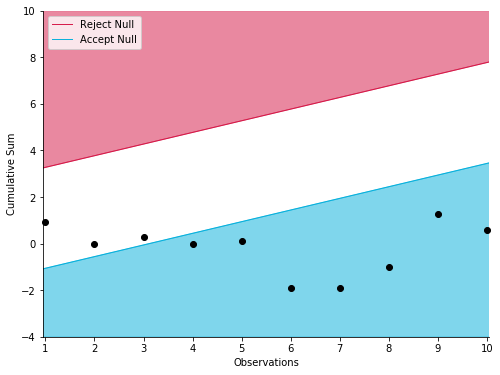

In [38]:
test.plot()

In [39]:
# увеличим количество сэмплов и их variance
test = sprt.SPRTNormal(alpha = 0.05, beta = 0.3, h0 = 0, h1 = 1, values = np.random.normal(0, 1, 1000), variance = 100)

Decision:	Accept

      values    lower    upper
n                             
991  -20.599  380.232  759.406
992  -20.015  380.732  759.906
993  -20.748  381.232  760.406
994  -20.258  381.732  760.906
995  -20.100  382.232  761.406
996  -19.932  382.732  761.906
997  -18.447  383.232  762.406
998  -19.012  383.732  762.906
999  -19.606  384.232  763.406
1000 -18.406  384.732  763.906


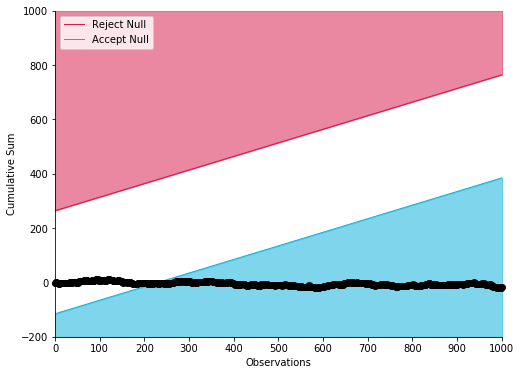

In [40]:
test.plot()

### 5*. Reservoir sampling

In [46]:
import random

def sample(iterable, n):
    """
    Sourse: Knuth, 1981
    Returns @param n random items from @param iterable.
    """
    reservoir = []
    for t, item in enumerate(iterable):
        if t < n:
            reservoir.append(item)
        else:
            m = random.randint(0,t)
            if m < n:
                reservoir[m] = item
    return reservoir

In [48]:
iterable=[7,4,3,5,5,9,2,34,0,4,3,5,34,3,4,3,21,5,7,3,1,1,1,111,2,5,7,6,99,99,97,3,3]
n=10
res=sample(iterable, n)

In [49]:
res

[7, 4, 3, 7, 99, 5, 3, 7, 3, 4]